# Titanic Dataset

**Author:** Kevin O'Hara<br>
**Email:** kohara91@gmail.com<br>
**LinkedIn:** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')

# Verify import
raw_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
raw_train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

From the above, we can see that passengerId gives us nothing to work with on predicting whether the passenger will live or die - it's just a unique number identifying them. This is about as helpful as their name. Their passengerId requires less cleaning so we will use that to differentiate folks. The ticket appears less important due to the number of unique values as well. We can probably get more pertinent information by looking at the ticket class and/or fare price.<br><br>
Let's see what some of the unique values are.

In [4]:
raw_train.Age.unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [5]:
raw_train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [6]:
raw_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

The cabin is mostly empty, so we can disregard that. The fare will give us a good idea as to the "class" or wealth level of the passenger. Ticket number won't be important, so we can remove. The wealth level may be a feature of interest so we'll keep the fare and Pclass to examine this<br><br>
The age on the other hand is mostly there. We can impute some values to fill it out.<br><br>
Let's explore the data a bit before we continue.

## EDA

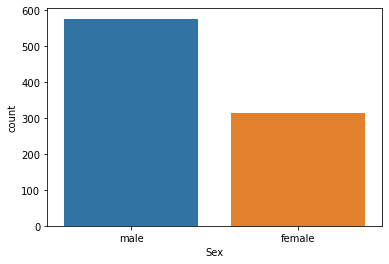

In [7]:
sns.countplot(x='Sex', data=raw_train)

There appear to be about twice the number of males as there are females on board the training set. We'll keep this in mind as we examine the impact of sex on survivability.

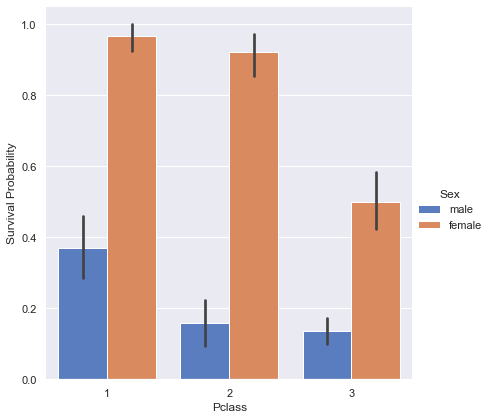

In [8]:
sns.set(style='darkgrid')

plot1 = sns.catplot(x='Pclass', y='Survived',
                    hue='Sex', data=raw_train,
                    height=6, kind='bar',
                    palette='muted')
plot1.despine(left=True)
plot1.set_ylabels('Survival Probability')

We can see that females had a much higher chance of surviving over men in all classes - though there is a considerable survival uptick with men in first class.

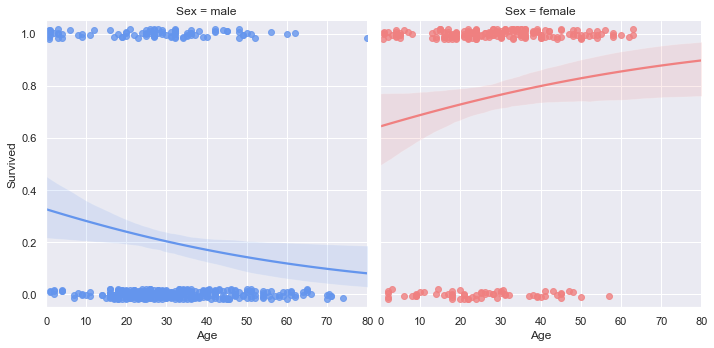

In [9]:
# Creating color palettes
pal = dict(male='#6495ED', female='#F08080')

# Survival probability as a function of age and sex
plot2 = sns.lmplot(x='Age', y='Survived',
                   col='Sex', hue='Sex',
                   data=raw_train, palette=pal,
                   y_jitter=.02, logistic=True,
                   truncate=False)
plot2.set(xlim=(0, 80), ylim=(-.05, 1.05))

The above shows that the chance of survival seemed to decrease in men as they got older, while women saw an uptick in survival. <br> <br>
Let's examine the ages a little deeper to get an idea of the ages ranges per class.

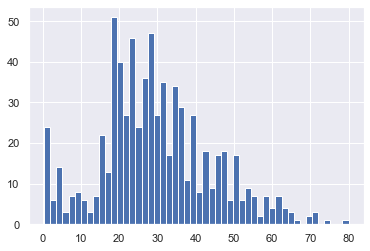

In [10]:
raw_train['Age'].hist(bins=50)

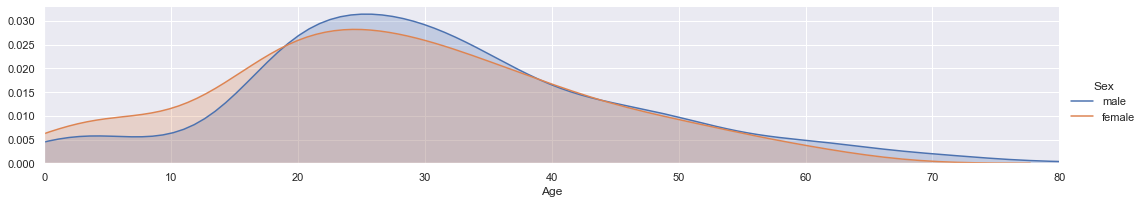

In [11]:
plot = sns.FacetGrid(raw_train, hue='Sex', aspect=5, legend_out=True)
plot.map(sns.kdeplot, 'Age', shade=True)
plot.set(xlim=(0, raw_train.Age.max()))
plot.add_legend()

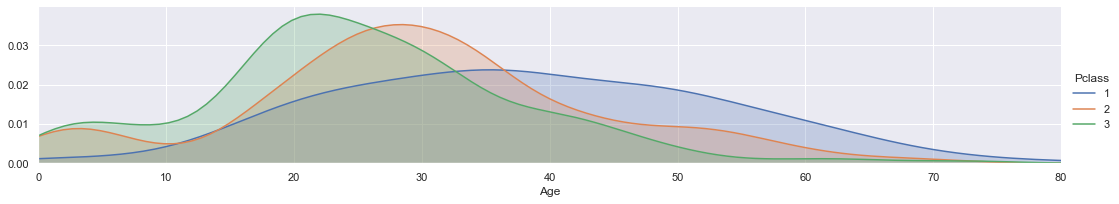

In [12]:
plot = sns.FacetGrid(raw_train, hue='Pclass', aspect=5, legend_out=True)
plot.map(sns.kdeplot, 'Age', shade=True)
plot.set(xlim=(0, raw_train.Age.max()))
plot.add_legend()

So we can see in the above that the median ages are roughly the same regardless of passenger Sex. Passengers appear to be younger on average in third class, and older as the classes get higher. Pclass 1 appears to be the most rounded with the most older passengers. 

In [13]:
# We'll drop these three columns because we can obtain the same/better feature
# information with the other columns
train_1 = raw_train.drop(['PassengerId', 'Cabin', 'Ticket', 'Name'], axis=1)

Now we need to clean the df a bit before we impute values. The cleaning we will do is:
* Engineer a new feature "Relatives" out of SibSp and Parch columns.
* Encode the Sex and Embarked values with a dummy encoder
* Scale/normalize the df

## Feature Engineering

In [14]:
data = [train_1]
for dataset in data:
    dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']

In [15]:
train_1.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [16]:
train_1.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Relatives
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


## Encoding Categorical Features

Before we encode, we need to fill in the few missing values in the Embarked column. Since there are only two (2/891) we can fill these in with the mode. 

In [17]:
train_1.Embarked.fillna(train_1.Embarked.mode()[0], inplace=True)

In [18]:
# Verify
train_1.isna().sum()

Survived       0
Pclass         0
Sex            0
Age          177
Fare           0
Embarked       0
Relatives      0
dtype: int64

Now we need to fill in the missing ages. Instead of a SimpleImputer, we will use the other features to our advantage by grouping and filling with the median of each group. From the above EDA, Sex and Pclass appear to be good candidates to group by and fill in an age with.

In [19]:
train_1.Age = train_1.Age.fillna(
              train_1.groupby(['Sex', 'Pclass']).Age.transform('median'))

In [20]:
# Verify
train_1.isna().sum()

Survived     0
Pclass       0
Sex          0
Age          0
Fare         0
Embarked     0
Relatives    0
dtype: int64

Last we'll tackle the last categorical feature using Pandas get_dummies.

In [21]:
train_2 = pd.get_dummies(data=train_1, columns=['Sex', 'Embarked'])
# Verify
train_2.head()

,Survived,Pclass,Age,Fare,Relatives,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,7.2500,1,0,1,0,0,1
1,1,1,38.0,71.2833,1,1,0,1,0,0
2,1,3,26.0,7.9250,0,1,0,0,0,1
3,1,1,35.0,53.1000,1,1,0,0,0,1
4,0,3,35.0,8.0500,0,0,1,0,0,1


## Scaling Data

Before scaling, we need to split the "Survived" column from the rest of the features.

In [22]:
X, y = train_2.iloc[:, train_2.columns != 'Survived'],\
       train_2.Survived

In [23]:
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X),
                           columns=X.columns)

# Verify
X_train_std.head()

,Pclass,Age,Fare,Relatives,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.827377,-0.534891,-0.502445,0.059160,-0.737695,0.737695,-0.482043,-0.307562,0.615838
1,-1.566107,0.668392,0.786845,0.059160,1.355574,-1.355574,2.074505,-0.307562,-1.623803
2,0.827377,-0.234070,-0.488854,-0.560975,1.355574,-1.355574,-0.482043,-0.307562,0.615838
3,-1.566107,0.442776,0.420730,0.059160,1.355574,-1.355574,-0.482043,-0.307562,0.615838
4,0.827377,0.442776,-0.486337,-0.560975,-0.737695,0.737695,-0.482043,-0.307562,0.615838


## Logistic Regression

With our data scaled - we'll start with a Logistic Regression. It's fairly simple and works well on linearly separable classes with standardized features. We will use the accuracy score in sci-kit learn as our metric.

In [24]:
lr_model = LogisticRegression(C=1.0,
                              n_jobs=-1,
                              random_state=42)
scores = cross_val_score(lr_model, X_train_std, y, cv=5)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

[0.77653631 0.79213483 0.79775281 0.81460674 0.82022472]
0.8002510827945514


Our first attempt went ok. We need to tune the C hyperparameter in our LR model now.

In [25]:
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

lr_search = GridSearchCV(lr_model,
                         param_grid,
                         scoring='accuracy',
                         cv=5,
                         n_jobs=-1).fit(X_train_std, y)

print('The best parameter here is:')
print('C:', lr_search.best_params_['C'])

lr_model2 = LogisticRegression(C=lr_search.best_params_['C'],
                               n_jobs=-1,
                               random_state=42)

scores = cross_val_score(lr_model2, X_train_std, y, cv=5)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

The best parameter here is:
C: 1
[0.77653631 0.79213483 0.79775281 0.81460674 0.82022472]
0.8002510827945514


No improvement here since the best C value happened to be the default. Before attempting something else, let's see what our feature importances are to try to improve the model with less.

In [26]:
# The lr_model variable already has the best C value
# so we will refit with that
lr_model.fit(X_train_std, y)

LogisticRegression(n_jobs=-1, random_state=42)

In [27]:
col = list(X_train_std.columns)
lr_coefs = pd.DataFrame(index=[0], columns=col)
lr_coefs.iloc[0:1, :] = lr_model.coef_
lr_coefs

,Pclass,Age,Fare,Relatives,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,-0.972111,-0.555716,0.099781,-0.36719,0.646965,-0.646965,0.084787,0.010661,-0.080986


From the above, we can see that the Fare and Embarked columns are of little importance. Pclass, Sex, Age, and Relatives all held a higher importance in the classifier success. Let's try re-fitting with the most important features and look at the accuracy

In [28]:
X_train_imp = X_train_std.drop(
              ['Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S'], axis=1)

# Verify
X_train_imp.head()

,Pclass,Age,Relatives,Sex_female,Sex_male
0,0.827377,-0.534891,0.059160,-0.737695,0.737695
1,-1.566107,0.668392,0.059160,1.355574,-1.355574
2,0.827377,-0.234070,-0.560975,1.355574,-1.355574
3,-1.566107,0.442776,0.059160,1.355574,-1.355574
4,0.827377,0.442776,-0.560975,-0.737695,0.737695


In [29]:
lr_search = GridSearchCV(lr_model,
                         param_grid,
                         scoring='accuracy',
                         cv=5,
                         n_jobs=-1).fit(X_train_imp, y)

print('The best parameter here is:')
print('C:', lr_search.best_params_['C'])

lr_model2 = LogisticRegression(C=lr_search.best_params_['C'],
                               n_jobs=-1,
                               random_state=42)

scores = cross_val_score(lr_model2, X_train_imp, y, cv=5)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

The best parameter here is:
C: 1
[0.79329609 0.79775281 0.80337079 0.80898876 0.80898876]
0.8024794425961961


Overall, an improvement but not a huge one. Our classifier went from ~80% accurate to ~80.2% with the less important features removed. Let's try another algorithm to see if we can get a better result - Random Forest.

## Random Forest

In [30]:
rf_model = RandomForestClassifier(n_jobs=-1,
                                  random_state=42)

scores = cross_val_score(rf_model, X_train_imp, y, cv=5)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

[0.77094972 0.80337079 0.80898876 0.80898876 0.83707865]
0.8058753373925052


First go is a little more accurate than our LR model - but there is a lot to tune here. Let's work on the hyperparameters to optimize this classifier

In [31]:
param_grid = {'n_estimators': [50, 100, 300, 500, 700],
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [1, 5, 10],
              'min_samples_split': [2, 4, 6, 8, 10]}

rf_search = GridSearchCV(rf_model,
                         param_grid,
                         scoring='accuracy',
                         cv=5,
                         n_jobs=-1).fit(X_train_imp, y)

print('The best parameters here are:')
print('n_estimators:', rf_search.best_params_['n_estimators'])
print('criterion:', rf_search.best_params_['criterion'])
print('min_samples_leaf:', rf_search.best_params_['min_samples_leaf'])
print('min_samples_split:', rf_search.best_params_['min_samples_split'])

rf_model2 = RandomForestClassifier(
    n_estimators=rf_search.best_params_['n_estimators'],
    criterion=rf_search.best_params_['criterion'],
    min_samples_leaf=rf_search.best_params_['min_samples_leaf'],
    min_samples_split=rf_search.best_params_['min_samples_split'],
    n_jobs=-1,
    random_state=42)

scores = cross_val_score(rf_model2, X_train_imp, y, cv=5)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

The best parameters here are:
n_estimators: 50
criterion: entropy
min_samples_leaf: 1
min_samples_split: 6
[0.81005587 0.82022472 0.8258427  0.83707865 0.83707865]
0.8260561170045824


This got us a very noticable accuracy increase - more than 2%! We're at ~82.6% accurate with this tuned RF model. Let's bring this model in to predict on the test data for our final result.

## Prepping Test Data

In [32]:
raw_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We will need to impute our Ages in the same way but are otherwise dropping columns and engineering the "Relatives" feature.

In [33]:
# Helper function for preparing test data
def prep_data(df):
    data = [df]
    for dataset in data:
        dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']
    df.drop(['PassengerId', 'Cabin', 'Ticket', 'Name',
             'SibSp', 'Parch'],
            axis=1, inplace=True)
    df.Age = df.Age.fillna(
             df.groupby(['Sex', 'Pclass']).Age.transform('median'))
    new_df = pd.get_dummies(data=df, columns=['Sex', 'Embarked'])
    std_df = pd.DataFrame(scaler.transform(new_df),
                          columns=new_df.columns)
    std_df.drop(['Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
                axis=1, inplace=True)
    return std_df

In [34]:
test_std = prep_data(raw_test)

# Verify
test_std.head()

,Pclass,Age,Relatives,Sex_female,Sex_male
0,0.827377,0.405174,-0.560975,-0.737695,0.737695
1,0.827377,1.345238,0.059160,1.355574,-1.355574
2,-0.369365,2.473316,-0.560975,-0.737695,0.737695
3,0.827377,-0.158865,-0.560975,-0.737695,0.737695
4,0.827377,-0.534891,0.679295,1.355574,-1.355574


## Final Predictions and Kaggle Submission

In [38]:
rf_model2.fit(X_train_imp, y)

RandomForestClassifier(criterion='entropy', min_samples_split=6,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [39]:
predictions = rf_model2.predict(test_std)

In [40]:
pass_id = pd.read_csv('test.csv')

submission = pd.DataFrame({
    'PassengerId': pass_id['PassengerId'],
    'Survived': predictions
})

# Verify
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [41]:
submission.to_csv('titanic_submission.csv', index=False)

## Summary

We were able to examine our Titanic training data and use a Logistic Regression model to obtain a baseline accuracy and the most influential features. After tuning our LR model, we took our scaled and engineered dataframe to a Random Forest Classifier. The RF model, after some tuning, proved to be 2% more accurate on our training data. We then took this model and used it to make predictions on our test data. After submitting it to Kaggle, we found that the final model accuracy came out to ~73%. This is ~10% worse than our training accuracy, which leads me to conclude that our RF model is overfitting the training data.  <br> <br>
There is certainly room for improvement but for now we will conclude this classification exercise. Any questions or further discussion please feel free to reach out via email or LinkedIn. I am always open for new ideas to improve and would enjoy expanding our networks.